# Part 4 - Hypothesis Testing

<center><img src="Images/banners/DALL-E-movie-banner_01.webp" width=800px alt="Successful Movie Banner - Made with DALL E"></center>

For part 4 of the project, I will be using my MySQL database from part 3 to answer meaningful questions for the stakeholder.

They want me to use your hypothesis testing and statistics knowledge to answer 3 questions about what makes a successful movie.

## Questions to Answer
- Q1: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates? If so, which rating earns the most revenue?

    - Q1B: What if compare ROI instead of revenue?s
 

- Q2; Do movies that are over 2 hours long earn more or less revenue than movies that are less than 2 hours long?

- Q3: Do movies released after 2020 earn less revenue than movies released before 2020?

- Q4: Do some movie genres earn more revenue than others?

<!-- 
- Q5: Are some genres more highly rated than others? -->

## Hypothesis Testing Workflow

In [1]:
# from IPython.display import Markdown
# with open("Reference/hypothesis_testing_workflow.md") as f:
#     how_to = f.read()
# Markdown(how_to)

## Hypothesis Testing Workflow 

#### Step 1: Select the Appropriate Hypothesis Test

- Q1: What type of data do I have (Numeric or categorical?)
- Q2: How many samples/groups am I comparing?

>Using the answers to the above 2 questions: select the type of test from this table.

| What type of comparison? | Numeric Data | Categorical Data|
| --- | --- | --- |
|Sample vs Known Quantity/Target|1 Sample T-Test| Binomial Test|
|2 Samples | 2 Sample T-Test| Chi-Square|
|More than 2| ANOVA and/or Tukey | Chi Square|

#### STEP 2:  Do we meet the assumptions of the chosen test?

- [One-Sample T-Test](https://statistics.laerd.com/spss-tutorials/one-sample-t-test-using-spss-statistics.php)
    - No significant outliers
    - Normality

- [Independent t-test (2-sample)](https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php)
    - No significant outliers
    - Normality
    - Equal Variance

- [One Way ANOVA](https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics.php)
    - No significant outliers
    - Equal variance
    - Normality

- [Chi-Square test](https://statistics.laerd.com/spss-tutorials/chi-square-test-for-association-using-spss-statistics.php)
    - Both variables are categorical

 
|Assumption test| Function |
| --- | --- |
| **Normality**| `scipy.stats.shapiro`|
| **Equal Variance** | `scipy.stats.levene`|


#### Step 3: Select Final Test Based on Checking Assumptions 

If we meet all of the assumptions, we can use 

> **Table Source: Parametric  T-Tests vs Non-Parametric Alternatives**
- [Choosing Between Parametric and Non-Parametric Tests](https://blog.minitab.com/blog/adventures-in-statistics-2/choosing-between-a-nonparametric-test-and-a-parametric-test)

- **Select the test from the right Nonparametric column that matches your Parametric t-test.** 

<!-- | Parametric tests (means) | Nonparametric tests (medians) |
 | --- | --- |
 | 1-sample t test | 1-sample Wilcoxon |
 | 2-sample t test | Mann-Whitney U test |
 | One-Way ANOVA | Kruskal-Wallis |
 -->

| Parametric tests (means) | Function | Nonparametric tests (medians) | Function |
 | --- | --- | --- | --- |
 | **1-sample t test** |`scipy.stats.ttest_1samp()`|  **1-sample Wilcoxon** |`scipy.stats.wilcoxon`|
 | **2-sample t test** |`scipy.stats.ttest_ind()` | **Mann-Whitney U test** |`scipy.stats.mannwhitneyu()` |
 | **One-Way ANOVA** | `scipy.stats.f_oneway()` | **Kruskal-Wallis** | `scipy.stats.kruskal` | 
 

- Perform the selected test to obtain the p-value to interpret.


#### STEP 4 Interpret Result & Post-Hoc Tests


- If p value is < $\alpha$:
    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
    
- If p<.05 AND you have multiple groups (i.e. ANOVA)
    - Perform a pairwise Tukey's  Multiuple Comparison test to determine which groups were significantly different.
    - [Tukey pairwise comparison test](https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html)
    - `statsmodels.stats.multicomp.pairwise_tukeyhsd`


# Imports and Loading

In [2]:
# Importing custom function for project
%load_ext autoreload
%autoreload 2
import project_functions as pf

In [3]:
!pip install -U dojo_ds -q
import dojo_ds as ds
ds.__version__

'1.0.9'

In [4]:
import os
results_dir = "Results/"
os.makedirs(results_dir, exist_ok=True)

In [5]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

fav_style = ('ggplot','fivethirtyeight')#,'tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [6]:
import sqlalchemy 
sqlalchemy.__version__

'1.4.49'

In [7]:
# !pip install pymysql
import pymysql
pymysql.install_as_MySQLdb()
from sqlalchemy import create_engine
from sqlalchemy import text
from sqlalchemy_utils import create_database, database_exists
from urllib.parse import quote_plus

## Getting mysql server password
import json
with open('/Users/codingdojo/.secret/mysql.json') as f:
    login = json.load(f)

login.keys()

dict_keys(['user', 'password', 'port', 'host', 'database'])

In [8]:
# from custom_functions import aws_mysql
# conn = aws_mysql.connect_to_aws_rds(creds_file="/Users/codingdojo/.secret/aws-personal.json")
# conn
connect_str = f"mysql+pymysql://{login['user']}:{quote_plus(login['password'])}@{login['host']}/{login['database']}"

## Check if database exists
if database_exists(connect_str) == False:
    raise Exception("Database doesn't exist!")
    # create_database(connect_str)
else:
    ## create engine
    engine = create_engine(connect_str)
    conn = engine.connect()
    print("[i] Successfully connected to database.")

[i] Successfully connected to database.


## SQL Query - Getting the Data

In [9]:
pd.read_sql("DESCRIBE tmdb",conn)

,Field,Type,Null,Key,Default,Extra
0,imdb_id,varchar(11),YES,,None,
1,id,bigint,NO,PRI,None,
2,budget,bigint,YES,,None,
3,revenue,bigint,YES,,None,
4,certification,varchar(8),YES,,None,
5,original_title,varchar(197),YES,,None,
6,overview,varchar(1001),YES,,None,
7,status,varchar(16),YES,,None,
8,homepage,varchar(268),YES,,None,
9,poster_path,varchar(33),YES,,None,


In [10]:
pd.read_sql("DESCRIBE title_basics",conn)

,Field,Type,Null,Key,Default,Extra
0,tconst,varchar(11),NO,PRI,None,
1,primaryTitle,varchar(209),YES,,None,
2,startYear,float,YES,,None,
3,runtimeMinutes,int,YES,,None,


### Query 1) Movie Certification, Runties, budget, revenue, and metadat

In [11]:
# Full Query
q = """
SELECT 
    tm.imdb_id,
    tb.primaryTitle,
    tm.release_date,
    tm.certification,
    tb.runtimeMinutes as runtime,
    tm.budget,
    tm.revenue
FROM
    tmdb tm
        JOIN
    title_basics tb ON tm.imdb_id = tb.tconst
WHERE
    tm.budget > 0 AND tm.revenue > 0
        AND tm.certification IS NOT NULL
        AND tm.certification NOT LIKE 'NR'
        AND tm.certification NOT LIKE 'NC%';
"""
df_full = pd.read_sql(text(q),conn)
df_full

,imdb_id,primaryTitle,release_date,certification,runtime,budget,revenue
0,tt0168629,Dancer in the Dark,2000-06-30,R,140,12500000,45600000
1,tt0314412,My Life Without Me,2003-03-07,R,106,2500000,12300000
2,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,PG-13,143,140000000,655011224
3,tt0266697,Kill Bill: Vol. 1,2003-10-10,R,111,30000000,180906076
4,tt0338013,Eternal Sunshine of the Spotless Mind,2004-03-19,R,108,20000000,72258126
...,...,...,...,...,...,...,...
3575,tt27439070,Miraculum,2022-06-15,PG-13,65,1000,1000
3576,tt19406606,The Shift,2023-11-30,PG-13,115,6500000,8500000
3577,tt21191906,After Death,2023-10-26,PG-13,108,40000000,11400000
3578,tt26459268,The Rise of Serio,2010-01-19,R,51,97000,1300000


In [12]:
from IPython.display import Markdown
## save preview for README
fname_md_data = results_dir+"sql-query-non-genres.md"
print(f'[i] Markdown Results Filename: {fname_md_data}')

export_to_md = ["- **SQL Query (For tests exlcuding genres)**",
                f"```SQL\n{q}\n```",
                "\n\n",
                "- **Preview of data:**",
                df_full.head().to_markdown()
                ]
export_to_md_final = '\n'.join(export_to_md)
Markdown(export_to_md_final)

[i] Markdown Results Filename: Results/sql-query-non-genres.md


- **SQL Query (For tests exlcuding genres)**
```SQL

SELECT 
    tm.imdb_id,
    tb.primaryTitle,
    tm.release_date,
    tm.certification,
    tb.runtimeMinutes as runtime,
    tm.budget,
    tm.revenue
FROM
    tmdb tm
        JOIN
    title_basics tb ON tm.imdb_id = tb.tconst
WHERE
    tm.budget > 0 AND tm.revenue > 0
        AND tm.certification IS NOT NULL
        AND tm.certification NOT LIKE 'NR'
        AND tm.certification NOT LIKE 'NC%';

```



- **Preview of data:**
|    | imdb_id   | primaryTitle                                           | release_date   | certification   |   runtime |    budget |   revenue |
|---:|:----------|:-------------------------------------------------------|:---------------|:----------------|----------:|----------:|----------:|
|  0 | tt0168629 | Dancer in the Dark                                     | 2000-06-30     | R               |       140 |  12500000 |  45600000 |
|  1 | tt0314412 | My Life Without Me                                     | 2003-03-07     | R               |       106 |   2500000 |  12300000 |
|  2 | tt0325980 | Pirates of the Caribbean: The Curse of the Black Pearl | 2003-07-09     | PG-13           |       143 | 140000000 | 655011224 |
|  3 | tt0266697 | Kill Bill: Vol. 1                                      | 2003-10-10     | R               |       111 |  30000000 | 180906076 |
|  4 | tt0338013 | Eternal Sunshine of the Spotless Mind                  | 2004-03-19     | R               |       108 |  20000000 |  72258126 |

In [13]:
# Save to md file
with open(fname_md_data,'w') as f:
    f.write(export_to_md_final)
    

In [14]:
# Test saved file
with open(fname_md_data,'r') as f:
    display(Markdown(f.read()))

- **SQL Query (For tests exlcuding genres)**
```SQL

SELECT 
    tm.imdb_id,
    tb.primaryTitle,
    tm.release_date,
    tm.certification,
    tb.runtimeMinutes as runtime,
    tm.budget,
    tm.revenue
FROM
    tmdb tm
        JOIN
    title_basics tb ON tm.imdb_id = tb.tconst
WHERE
    tm.budget > 0 AND tm.revenue > 0
        AND tm.certification IS NOT NULL
        AND tm.certification NOT LIKE 'NR'
        AND tm.certification NOT LIKE 'NC%';

```



- **Preview of data:**
|    | imdb_id   | primaryTitle                                           | release_date   | certification   |   runtime |    budget |   revenue |
|---:|:----------|:-------------------------------------------------------|:---------------|:----------------|----------:|----------:|----------:|
|  0 | tt0168629 | Dancer in the Dark                                     | 2000-06-30     | R               |       140 |  12500000 |  45600000 |
|  1 | tt0314412 | My Life Without Me                                     | 2003-03-07     | R               |       106 |   2500000 |  12300000 |
|  2 | tt0325980 | Pirates of the Caribbean: The Curse of the Black Pearl | 2003-07-09     | PG-13           |       143 | 140000000 | 655011224 |
|  3 | tt0266697 | Kill Bill: Vol. 1                                      | 2003-10-10     | R               |       111 |  30000000 | 180906076 |
|  4 | tt0338013 | Eternal Sunshine of the Spotless Mind                  | 2004-03-19     | R               |       108 |  20000000 |  72258126 |

In [15]:
df_full.duplicated(subset=['imdb_id']).sum()

0

### Query for Genres

In [16]:
pd.read_sql("DESCRIBE title_genres",conn)

,Field,Type,Null,Key,Default,Extra
0,tconst,text,YES,,None,
1,genre_id,bigint,YES,,None,


In [17]:
pd.read_sql("DESCRIBE genres",conn)

,Field,Type,Null,Key,Default,Extra
0,genre_name,text,YES,,None,
1,genre_id,bigint,NO,PRI,None,


In [18]:
# Full Query
q = """
SELECT 
    tm.imdb_id,
    tb.primaryTitle,
    tm.budget,
    tm.revenue,
    g.genre_name
FROM
    tmdb tm
        JOIN
    title_basics tb ON tm.imdb_id = tb.tconst
        JOIN
    title_genres tg ON tg.tconst = tb.tconst
        JOIN
    genres g ON g.genre_id = tg.genre_id
WHERE
    tm.budget > 0 AND tm.revenue > 0
    AND g.genre_name IS NOT NULL
    AND g.genre_name NOT LIKE "News";
"""
        # AND tm.certification IS NOT NULL
        # AND tm.certification NOT LIKE 'NR'
        # AND tm.certification NOT LIKE 'NC%';

df_genres =pd.read_sql(text(q),conn)
df_genres

,imdb_id,primaryTitle,budget,revenue,genre_name
0,tt0035423,Kate & Leopold,48000000,76019048,Comedy
1,tt0035423,Kate & Leopold,48000000,76019048,Fantasy
2,tt0035423,Kate & Leopold,48000000,76019048,Romance
3,tt0118589,Glitter,22000000,5271666,Drama
4,tt0118589,Glitter,22000000,5271666,Music
...,...,...,...,...,...
11859,tt9764362,The Menu,35000000,79628200,Horror
11860,tt9764362,The Menu,35000000,79628200,Thriller
11861,tt9777666,The Tomorrow War,200000000,14400000,Action
11862,tt9777666,The Tomorrow War,200000000,14400000,Adventure


In [19]:
## save preview for README
fname_md_data = results_dir+"sql-query-with-genres.md"
print(f'[i] Markdown Results Filename: {fname_md_data}')

export_to_md = ["- **SQL Query (For tests including genre)**",
                f"```SQL\n{q}\n```",
                "\n\n",
                "- **Preview of data:**",
                df_genres.head().to_markdown()
                ]
export_to_md_final = '\n'.join(export_to_md)
Markdown(export_to_md_final)

[i] Markdown Results Filename: Results/sql-query-with-genres.md


- **SQL Query (For tests including genre)**
```SQL

SELECT 
    tm.imdb_id,
    tb.primaryTitle,
    tm.budget,
    tm.revenue,
    g.genre_name
FROM
    tmdb tm
        JOIN
    title_basics tb ON tm.imdb_id = tb.tconst
        JOIN
    title_genres tg ON tg.tconst = tb.tconst
        JOIN
    genres g ON g.genre_id = tg.genre_id
WHERE
    tm.budget > 0 AND tm.revenue > 0
    AND g.genre_name IS NOT NULL
    AND g.genre_name NOT LIKE "News";

```



- **Preview of data:**
|    | imdb_id   | primaryTitle   |   budget |   revenue | genre_name   |
|---:|:----------|:---------------|---------:|----------:|:-------------|
|  0 | tt0035423 | Kate & Leopold | 48000000 |  76019048 | Comedy       |
|  1 | tt0035423 | Kate & Leopold | 48000000 |  76019048 | Fantasy      |
|  2 | tt0035423 | Kate & Leopold | 48000000 |  76019048 | Romance      |
|  3 | tt0118589 | Glitter        | 22000000 |   5271666 | Drama        |
|  4 | tt0118589 | Glitter        | 22000000 |   5271666 | Music        |

In [20]:
# Save to md file
with open(fname_md_data,'w') as f:
    f.write(export_to_md_final)

In [21]:
# Test saved file
with open(fname_md_data,'r') as f:
    display(Markdown(f.read()))

- **SQL Query (For tests including genre)**
```SQL

SELECT 
    tm.imdb_id,
    tb.primaryTitle,
    tm.budget,
    tm.revenue,
    g.genre_name
FROM
    tmdb tm
        JOIN
    title_basics tb ON tm.imdb_id = tb.tconst
        JOIN
    title_genres tg ON tg.tconst = tb.tconst
        JOIN
    genres g ON g.genre_id = tg.genre_id
WHERE
    tm.budget > 0 AND tm.revenue > 0
    AND g.genre_name IS NOT NULL
    AND g.genre_name NOT LIKE "News";

```



- **Preview of data:**
|    | imdb_id   | primaryTitle   |   budget |   revenue | genre_name   |
|---:|:----------|:---------------|---------:|----------:|:-------------|
|  0 | tt0035423 | Kate & Leopold | 48000000 |  76019048 | Comedy       |
|  1 | tt0035423 | Kate & Leopold | 48000000 |  76019048 | Fantasy      |
|  2 | tt0035423 | Kate & Leopold | 48000000 |  76019048 | Romance      |
|  3 | tt0118589 | Glitter        | 22000000 |   5271666 | Drama        |
|  4 | tt0118589 | Glitter        | 22000000 |   5271666 | Music        |

# Q1: Does MPAA rating affect revenue?

## Hypothesis
- $H_0$ (Null Hypothesis): All MPAA ratings generate have equal average revenue. 
- $H_A$ (Alternative Hypothesis):  Some MPAA ratings earn significantly more/less revenue than others.

### Selecting the Right Test
- We have Numerical Data
- with more than 2 groups
- We want a One way ANOVA

### ANOVA Assumptions
- No significant outliers
- Normality
- Equal Variance

In [22]:
df = df_full.copy()

### Checking for Box Office Earnings

In [23]:
df['certification'].value_counts(dropna=False)

R        1602
PG-13    1374
PG        528
G          76
Name: certification, dtype: int64

In [24]:
## checking for null values
df.isna().sum()

imdb_id          0
primaryTitle     0
release_date     0
certification    0
runtime          0
budget           0
revenue          0
dtype: int64

## Visualizing & Separating Groups

In [25]:
df_eda = df.copy()
df_eda.columns = [c.replace("_"," ").title() for c in df.columns]
df_eda

,Imdb Id,Primarytitle,Release Date,Certification,Runtime,Budget,Revenue
0,tt0168629,Dancer in the Dark,2000-06-30,R,140,12500000,45600000
1,tt0314412,My Life Without Me,2003-03-07,R,106,2500000,12300000
2,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,PG-13,143,140000000,655011224
3,tt0266697,Kill Bill: Vol. 1,2003-10-10,R,111,30000000,180906076
4,tt0338013,Eternal Sunshine of the Spotless Mind,2004-03-19,R,108,20000000,72258126
...,...,...,...,...,...,...,...
3575,tt27439070,Miraculum,2022-06-15,PG-13,65,1000,1000
3576,tt19406606,The Shift,2023-11-30,PG-13,115,6500000,8500000
3577,tt21191906,After Death,2023-10-26,PG-13,108,40000000,11400000
3578,tt26459268,The Rise of Serio,2010-01-19,R,51,97000,1300000


In [26]:
group_col = 'Certification'
measure_col = 'Revenue'

In [27]:
df_eda[group_col].unique()

array(['R', 'PG-13', 'PG', 'G'], dtype=object)

In [28]:
mill_fmt = pf.get_funcformatter(kind='m',prefix="$",float_fmt=',.0f')

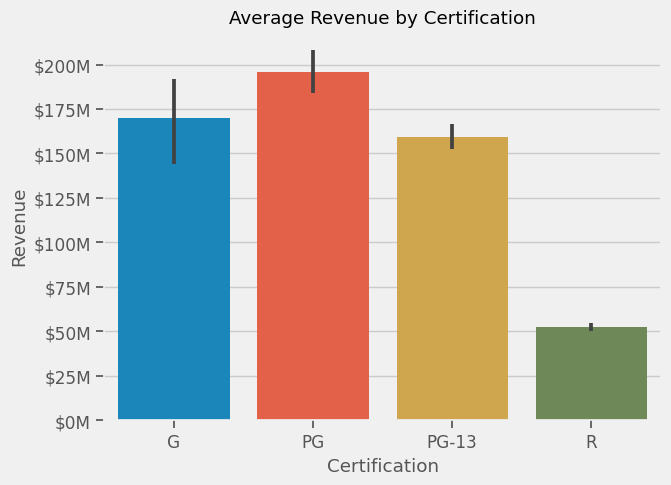

In [29]:
cert_order = ['G','PG','PG-13','R']
ax = sns.barplot(data=df_eda, x=group_col, y=measure_col, errorbar=('ci',68), order=cert_order)
ax.set_title(f"Average {measure_col} by {group_col}");
ax.yaxis.set_major_formatter(mill_fmt)

In [30]:
## Save certification groups revenue as dictonary
groups ={}

for group_name in df_eda[group_col].unique():
    temp = df_eda.loc[df_eda[group_col]== group_name, measure_col]
    groups[group_name] = temp

groups.keys()

dict_keys(['R', 'PG-13', 'PG', 'G'])

In [31]:
groups['G']

67      192610372
77      579700000
128     169332978
129     232225908
269      69500000
          ...    
2772       769028
3426    144327371
3430        50000
3442     10855626
3443         5000
Name: Revenue, Length: 76, dtype: int64

## Testing Assumptions

### Check for Normality

In [32]:
normality_results = pf.check_assumptions_normality(groups, as_markdown=True)
print(normality_results)

| group   |    n |    stat |           p |   p (.4) | sig?   |
|:--------|-----:|--------:|------------:|---------:|:-------|
| R       | 1602 | 0.57287 | 0           |        0 | True   |
| PG-13   | 1374 | 0.58601 | 0           |        0 | True   |
| PG      |  528 | 0.68657 | 4.01101e-30 |        0 | True   |
| G       |   76 | 0.71435 | 7.28273e-11 |        0 | True   |


- Didn't meet assumption of normality, but group n's are sufficiently large to safely disregard assumption of normality.


### No Outliers

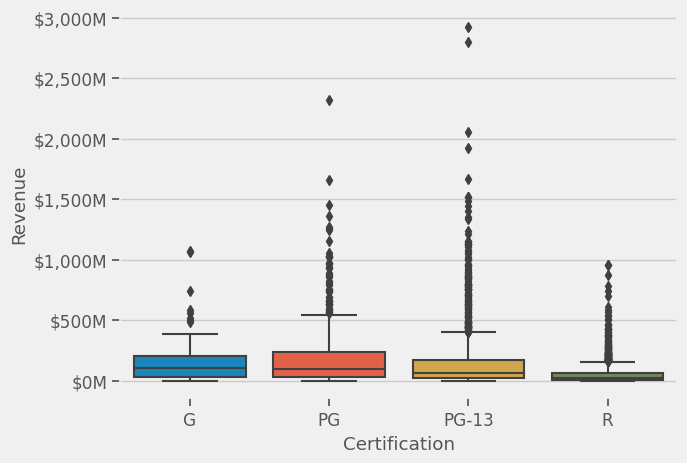

In [33]:
ax = sns.boxplot(data=df_eda, y=measure_col , x=group_col, order=cert_order);
ax.yaxis.set_major_formatter(mill_fmt)

In [34]:
def remove_and_display_outliers(groups, as_markdown=True):
    groups_cleaned = {}

    outlier_results = []

    for group_name, data in groups.items():
    
        outliers = np.abs(stats.zscore(data)) > 3

        
        outlier_results.append({'group':group_name,
                               'n (original)': len(data),
                               '# outliers': outliers.sum(),
                               "% outliers":f"{outliers.sum()/len(outliers)*100: .2f}%"
                               })
        # print(f"There were {} ({outliers.sum()/len(outliers)*100:.2f}%) outliers in the {sector} group.")
    
        group_data = data.loc[~outliers]
        groups_cleaned[group_name] = group_data

        # Formatting results
        results_df = pd.DataFrame(outlier_results)
        results_df = results_df.sort_values('group', ascending=True)
        
    if as_markdown == True:
        results_df = results_df.to_markdown(index=False)   
        print(results_df)
    else:
        display(results_df)
    return groups_cleaned#, results_df


groups_cleaned = remove_and_display_outliers(groups)


| group   |   n (original) |   # outliers | % outliers   |
|:--------|---------------:|-------------:|:-------------|
| G       |             76 |            2 | 2.63%        |
| PG      |            528 |           13 | 2.46%        |
| PG-13   |           1374 |           30 | 2.18%        |
| R       |           1602 |           36 | 2.25%        |


In [35]:
# groups_cleaned = {}

# for sector, data in groups.items():

#     outliers = np.abs(stats.zscore(data)) > 3
#     print(f"There were {outliers.sum()} ({outliers.sum()/len(outliers)*100:.2f}%) outliers in the {sector} group.")

#     group_data = data.loc[~outliers]
#     groups_cleaned[sector] = group_data

> I am torn about outlier removal. It may be best to leave in outliers and perform the non-parametric test instead.

### Checking for Equal Var

In [36]:
## Check for equal variance
result = stats.levene(*groups_cleaned.values())
print(result)
if result.pvalue < .05:
    print(f"- The groups do NOT have equal variance.")
else:
    print(f"- The groups DO have equal variance.")

LeveneResult(statistic=114.28641279259686, pvalue=1.3454791463102724e-70)
- The groups do NOT have equal variance.


-  Groups do not have equal variance. Therefore, use Kruskal Wallace instead of one-way ANOVA.

### Kruskal Wallis Test

In [37]:
## Running Krukal Test for Original Hypothesis
result = stats.kruskal(*groups_cleaned.values())
# result = stats.f_oneway(*groups.values())
print(result)
result.pvalue<.05

KruskalResult(statistic=475.2106095783153, pvalue=1.1236250591779874e-102)


True

- Our Kruskal Wallis test returned a p-value <.0001. 
- There is a significant difference in the average revenue for different movie certifications.
- A post-hoc test is needed to determine which ratings were different.

### Post-Hoc Tukey's Multiple Comparison

In [38]:
# ## make a list for saving the dataframes to
# tukeys_dfs = []
# for cert, temp in groups.items():
#     temp_df = pd.DataFrame({'Revenue':temp, 'Certification':cert})
#     tukeys_dfs.append(temp_df)
    
# ## concatenate them into 1 dataframe    
# tukeys_data = pd.concat(tukeys_dfs)
# tukeys_data

tukeys_data = pf.prep_data_for_tukeys(groups_cleaned, group_col=group_col, values_col=measure_col)
tukeys_data

,Revenue,Certification
0,45600000.0,R
1,12300000.0,R
3,180906076.0,R
4,72258126.0,R
5,60740827.0,R
...,...,...
2772,769028.0,G
3426,144327371.0,G
3430,50000.0,G
3442,10855626.0,G


In [39]:
tukeys_data[group_col].value_counts()

R        1566
PG-13    1344
PG        515
G          74
Name: Certification, dtype: int64

In [40]:
## Post Hoc
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [41]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(tukeys_data[measure_col],tukeys_data[group_col])
display(tukeys_results.summary())

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,22365342.1324,0.6143,-24763540.9256,69494225.1903,False
G,PG-13,-13536296.5139,0.8686,-58802241.9315,31729648.9037,False
G,R,-103245893.7041,0.0,-148344088.6404,-58147698.7679,True
PG,PG-13,-35901638.6462,0.0,-55548148.9444,-16255128.348,True
PG,R,-125611235.8365,0.0,-144868097.9603,-106354373.7126,True
PG-13,R,-89709597.1902,0.0,-103805729.1106,-75613465.2699,True


> According to the post-hoc Tukey's tests, G/PG/PG-13 movies make similar average revenue than all other ratings. PG movies make more money than PG-13.
> R-rated movied make significantly less revenue than every other genre.

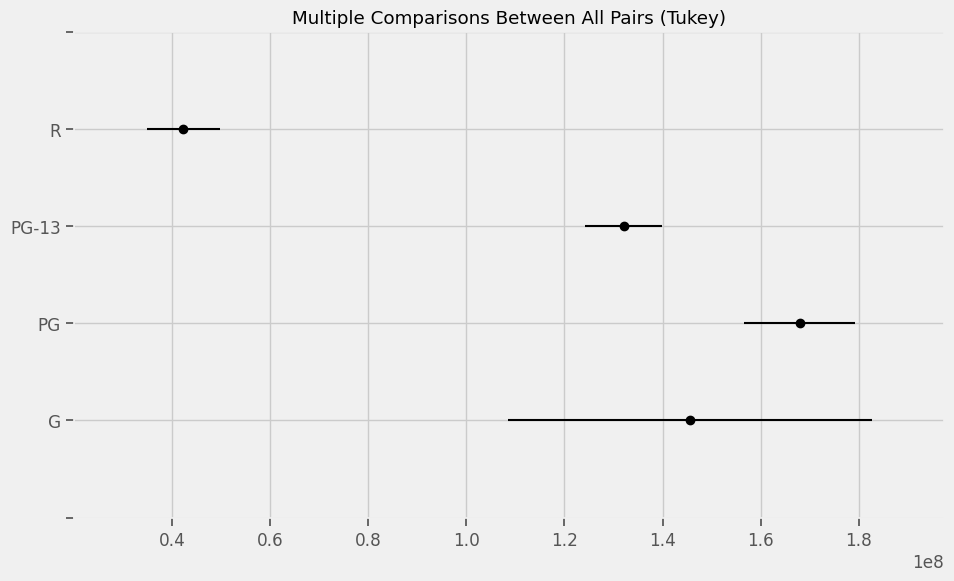

In [42]:
tukeys_results.plot_simultaneous();

- Figure saved as Images/hypotheses/revnue_mpaa_rating.png


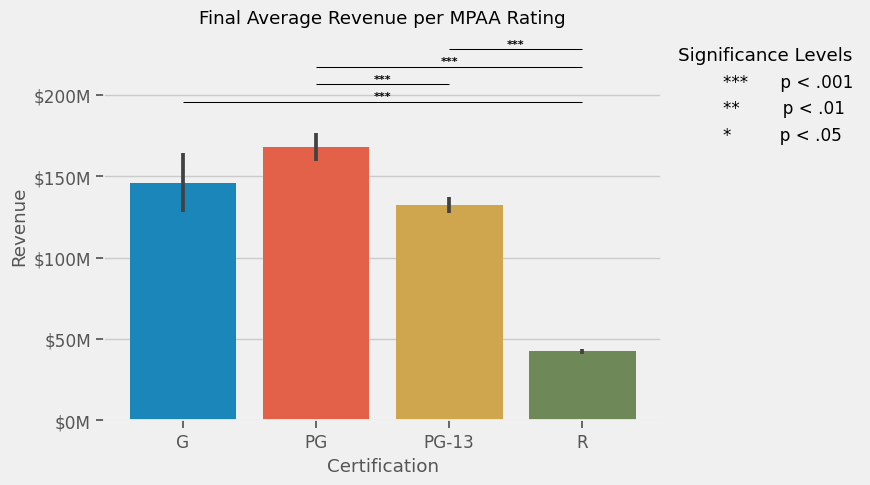

In [43]:
# Example usage remains the same
ax = sns.barplot(data=tukeys_data, x=group_col, y=measure_col, errorbar=('ci', 68), order=cert_order)
ax.yaxis.set_major_formatter(mill_fmt)
ax.set_title("Final Average Revenue per MPAA Rating")
# Call the annotation function
pf.annotate_tukey_significance(ax, tukeys_results)#, delta_pad_text=0.02)
pf.savefig('Images/hypotheses/revnue_mpaa_rating.png',ax=ax)#facecolor='white')

# Q2; Do movies that are over 2 hours long earn more or less revenue than movies that are less than 2 hours long?


## Hypothesis
- $H_0$ (Null Hypothesis): Movies longer than 2 hours generate the same average revenue as shorter movies.
- $H_A$ (Alternative Hypothesis):  Movies longer than 2 hours generate more/less average revenue than shorter movies.

### Selecting the Right Test
- We have Numerical Data
- with 2 groups
- 2-sample t-test A.K.A. Independent T-Test

### T-Test Assumptions
- No significant outliers
- Normality
- Equal Variance

## Visualizing & Separating Groups

In [44]:
df_eda = df.copy()
group_map ={True:"2+ hours",
           False:"<2 hours"}
df_eda['runtime_group'] = (df_eda['runtime'] > (2*60)).map(group_map)

df_eda.columns = [c.replace("_"," ").title() for c in df_eda.columns]
df_eda

,Imdb Id,Primarytitle,Release Date,Certification,Runtime,Budget,Revenue,Runtime Group
0,tt0168629,Dancer in the Dark,2000-06-30,R,140,12500000,45600000,2+ hours
1,tt0314412,My Life Without Me,2003-03-07,R,106,2500000,12300000,<2 hours
2,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,PG-13,143,140000000,655011224,2+ hours
3,tt0266697,Kill Bill: Vol. 1,2003-10-10,R,111,30000000,180906076,<2 hours
4,tt0338013,Eternal Sunshine of the Spotless Mind,2004-03-19,R,108,20000000,72258126,<2 hours
...,...,...,...,...,...,...,...,...
3575,tt27439070,Miraculum,2022-06-15,PG-13,65,1000,1000,<2 hours
3576,tt19406606,The Shift,2023-11-30,PG-13,115,6500000,8500000,<2 hours
3577,tt21191906,After Death,2023-10-26,PG-13,108,40000000,11400000,<2 hours
3578,tt26459268,The Rise of Serio,2010-01-19,R,51,97000,1300000,<2 hours


In [45]:
group_col = "Runtime Group"
measure_col = "Revenue"

In [46]:
mill_fmt = pf.get_funcformatter(kind='m',prefix="$",float_fmt=',.0f')

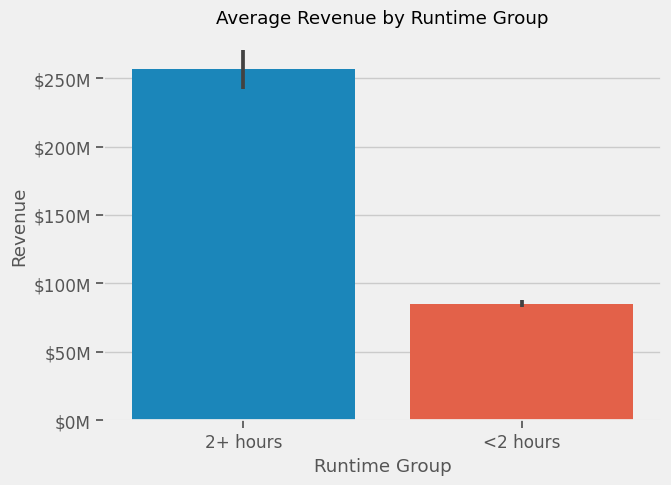

In [47]:
# runtime_order = ['G','PG','PG-13','R']
ax = sns.barplot(data=df_eda, x=group_col, y=measure_col, errorbar=('ci',68))#, order=cert_order)
ax.set_title(f"Average {measure_col} by {group_col}");
ax.yaxis.set_major_formatter(mill_fmt)

In [48]:
## Save certification groups revenue as dictonary
groups ={}

for cert in df_eda[group_col].unique():
    temp = df_eda.loc[df_eda[group_col]== cert, measure_col]
    groups[cert] = temp

groups.keys()

dict_keys(['2+ hours', '<2 hours'])

In [49]:
groups['2+ hours']

0        45600000
2       655011224
11       85306374
12      871368364
13      926287400
          ...    
3541    169000000
3542    108961677
3552      3000000
3553    121700000
3567     20800000
Name: Revenue, Length: 664, dtype: int64

## Testing Assumptions

### Check for Normality

In [50]:
normality_results = pf.check_assumptions_normality(groups, as_markdown=True)
print(normality_results)

| group    |    n |    stat |          p |   p (.4) | sig?   |
|:---------|-----:|--------:|-----------:|---------:|:-------|
| 2+ hours |  664 | 0.68894 | 3.4863e-33 |        0 | True   |
| <2 hours | 2916 | 0.57219 | 0          |        0 | True   |


- Didn't meet assumption of normality, but n is sufficiently large to disregard assumption of normality.


### No Outliers

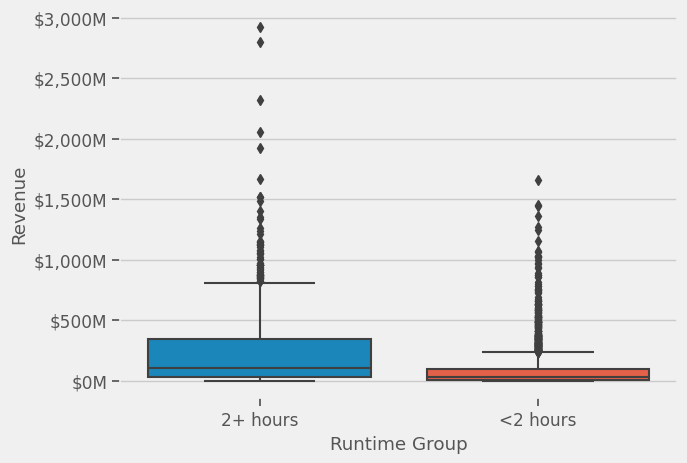

In [51]:
ax = sns.boxplot(data=df_eda,y=measure_col , x=group_col);
ax.yaxis.set_major_formatter(mill_fmt)

In [52]:
# groups_cleaned = {}

# for sector, data in groups.items():

#     outliers = np.abs(stats.zscore(data)) > 3
#     print(f"There were {outliers.sum()} ({outliers.sum()/len(outliers)*100:.2f}%) outliers in the {sector} group.")

#     group_data = data.loc[~outliers]
#     groups_cleaned[sector] = group_data

We will remove the small number of outliers in runtime.

In [53]:
## Remove outliers
groups_cleaned = remove_and_display_outliers(groups)


| group    |   n (original) |   # outliers | % outliers   |
|:---------|---------------:|-------------:|:-------------|
| 2+ hours |            664 |           11 | 1.66%        |
| <2 hours |           2916 |           65 | 2.23%        |


### Checking for Equal Var

In [54]:
## Check for equal variance
result = stats.levene(*groups_cleaned.values())
print(result)
if result.pvalue < .05:
    print(f"- The groups do NOT have equal variance.")
else:
    print(f"- The groups DO have equal variance.")

LeveneResult(statistic=527.872338946773, pvalue=6.35084984584201e-109)
- The groups do NOT have equal variance.


-  Groups do not have equal variance. Therefore, use Mann Whitney U test

### Final Test - Mann Whitney U

In [55]:
result = stats.mannwhitneyu(*groups_cleaned.values())
print(result)
result.pvalue <.05

MannwhitneyuResult(statistic=1312978.5, pvalue=2.3697632561755602e-60)


True

Our U-test had a significant p-value (p<.001) so we reject the null hypothesis that movie movies longer than 2 hours earn the same average revenue as shorter movies. We therefore conclude that there is movies with runtimes longer than 2 hours make significantly more than movies less than 2 hour long.

#### Visualizing Final Clean Results

- Getting Annotated Result.

In [56]:
final_plot_df = pf.prep_data_for_tukeys(groups_cleaned,group_col=group_col, values_col=measure_col)
final_plot_df.head()

,Revenue,Runtime Group
0,45600000.0,2+ hours
2,655011224.0,2+ hours
11,85306374.0,2+ hours
12,871368364.0,2+ hours
13,926287400.0,2+ hours


In [57]:
# Get simulated tukeys table for annotation function
results_to_annotate_df = pf.simulate_tukeys_results(groups_cleaned, result)
results_to_annotate_df

,group1,group2,p-adj,reject
0,2+ hours,<2 hours,2.369763e-60,True


- Figure saved as Images/hypotheses/revenue-by-runtime-group.png


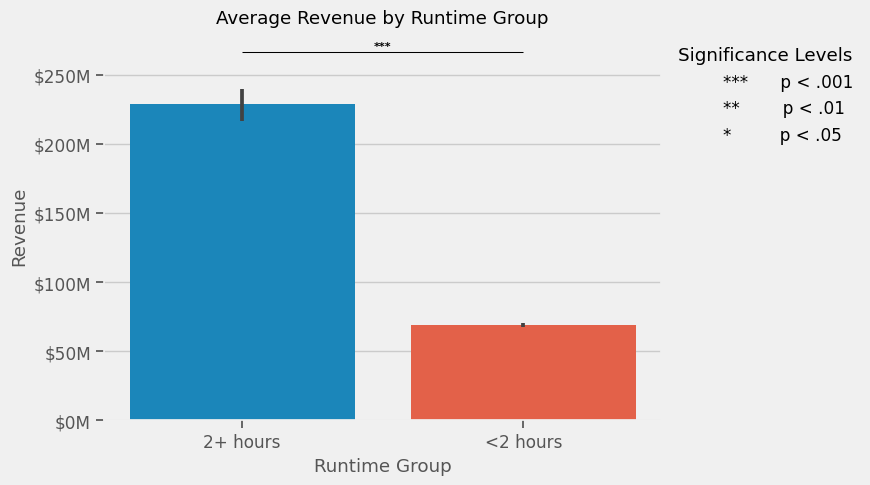

In [58]:
ax = sns.barplot(data=final_plot_df, x=group_col, y=measure_col, errorbar=('ci',68))
ax.set_title(f"Average {measure_col} by {group_col}");
ax.yaxis.set_major_formatter(mill_fmt)
pf.annotate_tukey_significance(ax, results_to_annotate_df)
pf.savefig('Images/hypotheses/revenue-by-runtime-group.png',ax=ax)

# Q3: Do movies released after 2020 earn less revenue than movies released before 2020?


## Hypothesis
- $H_0$ (Null Hypothesis): Movies released before 2020 earn the same revenue as movies released during or after 2020.
- $H_A$ (Alternative Hypothesis): Movies released before 2020 earn more revenue than movies released during or after 2020.

### Selecting the Right Test
- We have Numerical Data
- with 2 groups
- 2-sample t-test A.K.A. Independent T-Test

### T-Test Assumptions
- No significant outliers
- Normality
- Equal Variance

## Visualizing & Separating Groups

In [59]:
df['release_date'] = pd.to_datetime( df['release_date'])
df['year_released'] = df['release_date'].dt.year
df

,imdb_id,primaryTitle,release_date,certification,runtime,budget,revenue,year_released
0,tt0168629,Dancer in the Dark,2000-06-30,R,140,12500000,45600000,2000
1,tt0314412,My Life Without Me,2003-03-07,R,106,2500000,12300000,2003
2,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,PG-13,143,140000000,655011224,2003
3,tt0266697,Kill Bill: Vol. 1,2003-10-10,R,111,30000000,180906076,2003
4,tt0338013,Eternal Sunshine of the Spotless Mind,2004-03-19,R,108,20000000,72258126,2004
...,...,...,...,...,...,...,...,...
3575,tt27439070,Miraculum,2022-06-15,PG-13,65,1000,1000,2022
3576,tt19406606,The Shift,2023-11-30,PG-13,115,6500000,8500000,2023
3577,tt21191906,After Death,2023-10-26,PG-13,108,40000000,11400000,2023
3578,tt26459268,The Rise of Serio,2010-01-19,R,51,97000,1300000,2010


In [60]:
df_eda = df.copy()
group_map ={True:"2020+",
           False:"<2020"}

df_eda['Year Released Group'] = (df_eda['year_released'] >=2020).map(group_map)

df_eda.columns = [c.replace("_"," ").title() for c in df_eda.columns]
df_eda

,Imdb Id,Primarytitle,Release Date,Certification,Runtime,Budget,Revenue,Year Released,Year Released Group
0,tt0168629,Dancer in the Dark,2000-06-30,R,140,12500000,45600000,2000,<2020
1,tt0314412,My Life Without Me,2003-03-07,R,106,2500000,12300000,2003,<2020
2,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,PG-13,143,140000000,655011224,2003,<2020
3,tt0266697,Kill Bill: Vol. 1,2003-10-10,R,111,30000000,180906076,2003,<2020
4,tt0338013,Eternal Sunshine of the Spotless Mind,2004-03-19,R,108,20000000,72258126,2004,<2020
...,...,...,...,...,...,...,...,...,...
3575,tt27439070,Miraculum,2022-06-15,PG-13,65,1000,1000,2022,2020+
3576,tt19406606,The Shift,2023-11-30,PG-13,115,6500000,8500000,2023,2020+
3577,tt21191906,After Death,2023-10-26,PG-13,108,40000000,11400000,2023,2020+
3578,tt26459268,The Rise of Serio,2010-01-19,R,51,97000,1300000,2010,<2020


In [61]:
group_col = 'Year Released Group'
measure_col = "Revenue"

In [62]:
mill_fmt = pf.get_funcformatter(kind='m',prefix="$",float_fmt=',.0f')

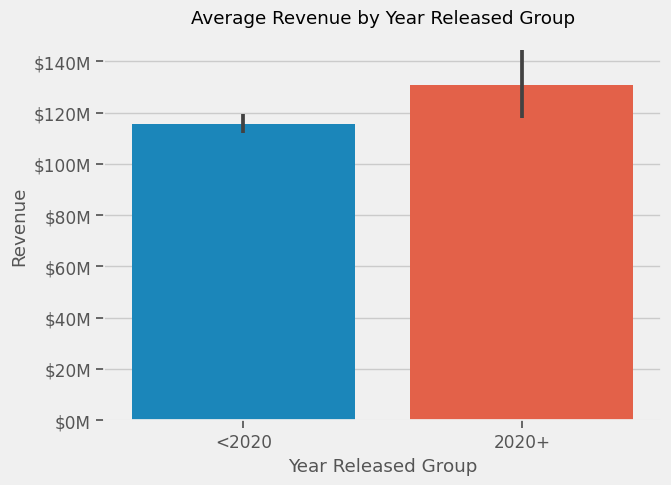

In [63]:
# runtime_order = ['G','PG','PG-13','R']
ax = sns.barplot(data=df_eda, x=group_col, y=measure_col, errorbar=('ci',68))#, order=cert_order)
ax.set_title(f"Average {measure_col} by {group_col}");
ax.yaxis.set_major_formatter(mill_fmt)

In [64]:
## Save certification groups revenue as dictonary
groups ={}

for group_name in df_eda[group_col].unique():
    temp = df_eda.loc[df_eda[group_col]== group_name, measure_col]
    groups[group_name] = temp

groups.keys()

dict_keys(['<2020', '2020+'])

In [65]:
groups['2020+']

1698     426500000
2057    2320250281
2526       2200000
2599       2000000
2698     268400000
           ...    
3573       7300000
3574        305526
3575          1000
3576       8500000
3577      11400000
Name: Revenue, Length: 365, dtype: int64

## Testing Assumptions

### Check for Normality

In [66]:
normality_results = pf.check_assumptions_normality(groups, as_markdown=True)
print(normality_results)

| group   |    n |    stat |           p |   p (.4) | sig?   |
|:--------|-----:|--------:|------------:|---------:|:-------|
| <2020   | 3215 | 0.54951 | 0           |        0 | True   |
| 2020+   |  365 | 0.51698 | 2.28204e-30 |        0 | True   |


- Didn't meet assumption of normality, but n is sufficiently large to disregard assumption of normality.


### No Outliers

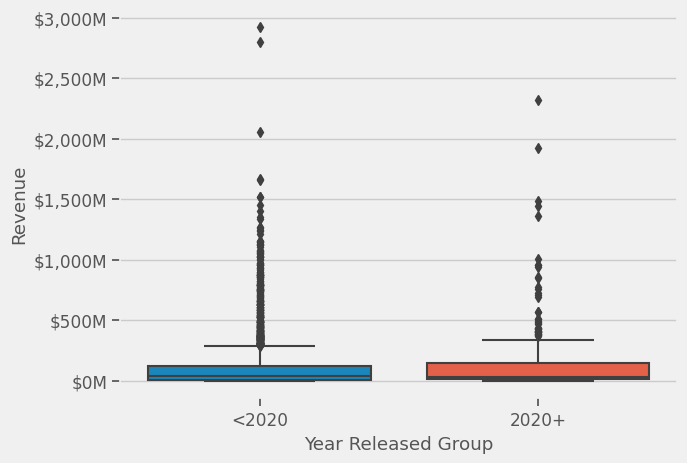

In [67]:
ax = sns.boxplot(data=df_eda,y=measure_col , x=group_col);
ax.yaxis.set_major_formatter(mill_fmt)

In [68]:
# groups_cleaned = {}

# for sector, data in groups.items():

#     outliers = np.abs(stats.zscore(data)) > 3
#     print(f"There were {outliers.sum()} ({outliers.sum()/len(outliers)*100:.2f}%) outliers in the {sector} group.")

#     group_data = data.loc[~outliers]
#     groups_cleaned[sector] = group_data

## Remove outliers
groups_cleaned = remove_and_display_outliers(groups)


| group   |   n (original) |   # outliers | % outliers   |
|:--------|---------------:|-------------:|:-------------|
| 2020+   |            365 |            9 | 2.47%        |
| <2020   |           3215 |           90 | 2.80%        |


We will remove the small number of outliers in runtime.

### Checking for Equal Var

In [69]:
## Check for equal variance
result = stats.levene(*groups_cleaned.values())
print(result)
if result.pvalue < .05:
    print(f"- The groups do NOT have equal variance.")
else:
    print(f"- The groups DO have equal variance.")

LeveneResult(statistic=3.2007677957173684, pvalue=0.07369067470860166)
- The groups DO have equal variance.


-  Groups have equal variance. Therefore, we will run planned 2-sample T-test>

### Final Test - 2-Sample T-Test

In [70]:
result = stats.ttest_ind(*groups_cleaned.values())
print(result)
result.pvalue <.05

Ttest_indResult(statistic=-1.4403686474133954, pvalue=0.14985311221809952)


False

Our 2-sample T-test had a p-value=.14, so we fail to reject the null hypothesis that movies released after 2020 earn less average revenue than movies released before 2020. 


#### Visualizing Final Clean Results

- Getting Annotated Result.

In [71]:
final_plot_df = pf.prep_data_for_tukeys(groups_cleaned,group_col=group_col, values_col=measure_col)
final_plot_df.head()

,Revenue,Year Released Group
0,45600000.0,<2020
1,12300000.0,<2020
2,655011224.0,<2020
3,180906076.0,<2020
4,72258126.0,<2020


In [72]:
# Get simulated tukeys table for annotation function
results_to_annotate_df = pf.simulate_tukeys_results(groups_cleaned, result)
results_to_annotate_df

,group1,group2,p-adj,reject
0,<2020,2020+,0.149853,False


- Figure saved as Images/hypotheses/revenue-by-year-released.png


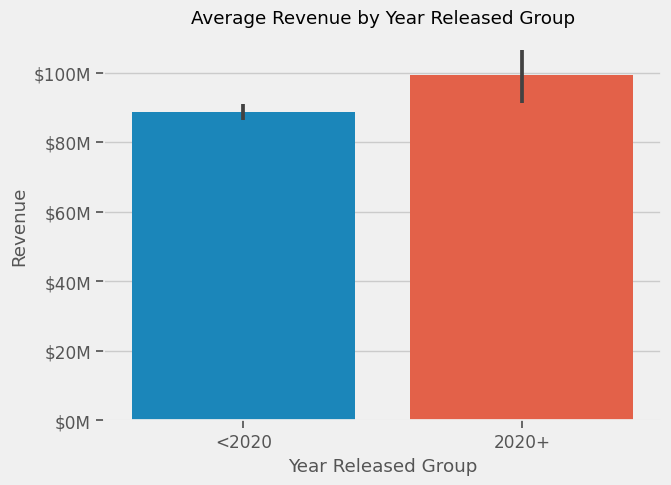

In [73]:
ax = sns.barplot(data=final_plot_df, x=group_col, y=measure_col, errorbar=('ci',68))
ax.set_title(f"Average {measure_col} by {group_col}");
ax.yaxis.set_major_formatter(mill_fmt)
# pf.annotate_tukey_significance(ax, results_to_annotate_df)
pf.savefig('Images/hypotheses/revenue-by-year-released.png',ax=ax)

# Q4: Do some movie genres earn more revenue than others?


## Hypothesis
- $H_0$ (Null Hypothesis): All genres earn the same average revenue.
- $H_A$ (Alternative Hypothesis): Some genres earn significantly more or less revenue than others.

### Selecting the Right Test
- We have Numerical Data
- with >2 groups
- One-Way ANOVA

### ANOVA Assumptions
- No significant outliers
- Normality
- Equal Variance

## Visualizing & Separating Groups

In [74]:
df_eda = df_genres.copy()
# group_map ={True:"2020+",
#            False:"<2020"}

# df_eda['Year Released Group'] = (df_eda['year_released'] >=2020).map(group_map)

df_eda.columns = [c.replace("_"," ").title() for c in df_eda.columns]
df_eda

,Imdb Id,Primarytitle,Budget,Revenue,Genre Name
0,tt0035423,Kate & Leopold,48000000,76019048,Comedy
1,tt0035423,Kate & Leopold,48000000,76019048,Fantasy
2,tt0035423,Kate & Leopold,48000000,76019048,Romance
3,tt0118589,Glitter,22000000,5271666,Drama
4,tt0118589,Glitter,22000000,5271666,Music
...,...,...,...,...,...
11859,tt9764362,The Menu,35000000,79628200,Horror
11860,tt9764362,The Menu,35000000,79628200,Thriller
11861,tt9777666,The Tomorrow War,200000000,14400000,Action
11862,tt9777666,The Tomorrow War,200000000,14400000,Adventure


In [75]:
group_col = 'Genre Name'
measure_col = "Revenue"

In [76]:
mill_fmt = pf.get_funcformatter(kind='m',prefix="$",float_fmt=',.0f')

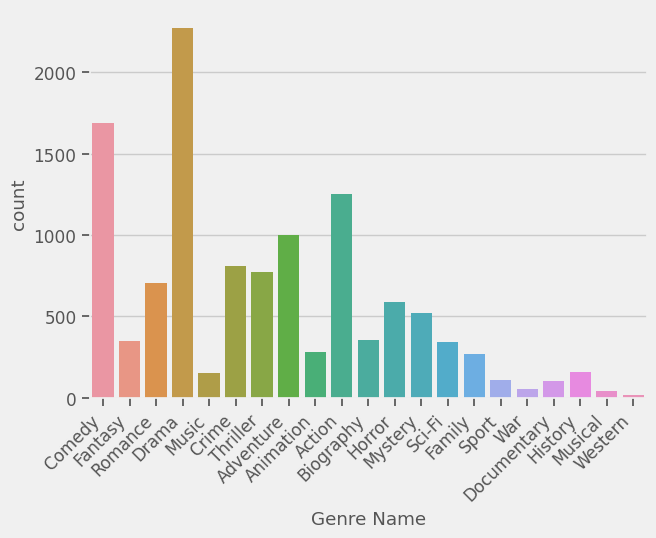

In [77]:
ax = sns.countplot(data=df_eda, x=group_col)#,order=genre_order)
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, ha='right');

In [78]:
# Calc order based on average revenue
genre_order = df_eda.groupby('Genre Name')['Revenue'].mean().sort_values(ascending=False).index
genre_order

Index(['Animation', 'Adventure', 'Sci-Fi', 'Fantasy', 'Action', 'Family',
       'Comedy', 'Thriller', 'Musical', 'Mystery', 'Crime', 'Drama', 'Western',
       'Biography', 'Romance', 'Horror', 'History', 'Music', 'War', 'Sport',
       'Documentary'],
      dtype='object', name='Genre Name')

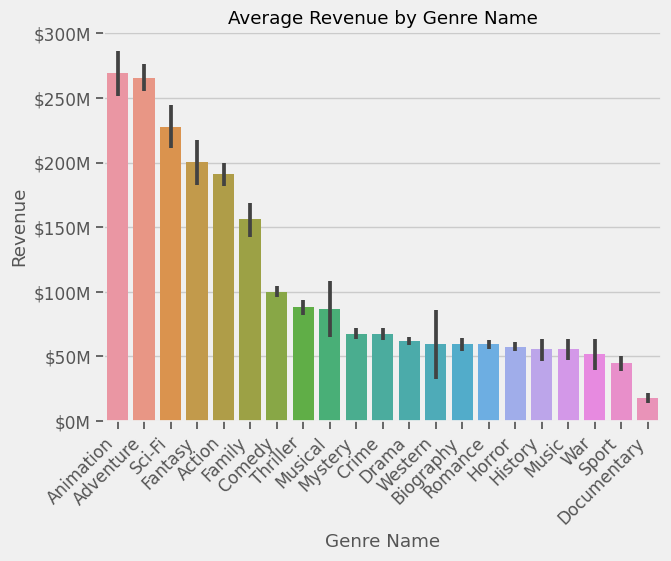

In [79]:
# runtime_order = ['G','PG','PG-13','R']
ax = sns.barplot(data=df_eda, x=group_col, y=measure_col, errorbar=('ci',68), order=genre_order)
fig = ax.get_figure()
ax.set_title(f"Average {measure_col} by {group_col}");
ax.yaxis.set_major_formatter(mill_fmt)
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, ha='right')
# ax.tick_params(axis='x', rotation=45, ha='right')
fig.align_xlabels(axs=ax)


In [80]:
## Save genre groups revenue as dictonary
groups ={}

for group_name in df_eda[group_col].unique():
    temp = df_eda.loc[df_eda[group_col]== group_name, measure_col]
    groups[group_name] = temp

groups.keys()

dict_keys(['Comedy', 'Fantasy', 'Romance', 'Drama', 'Music', 'Crime', 'Thriller', 'Adventure', 'Animation', 'Action', 'Biography', 'Horror', 'Mystery', 'Sci-Fi', 'Family', 'Sport', 'War', 'Documentary', 'History', 'Musical', 'Western'])

In [81]:
groups["Action"]

12       333535934
21       871368364
27       546400000
30       103000000
34       296339527
           ...    
11831           10
11837    567500000
11846        99924
11852    375063347
11861     14400000
Name: Revenue, Length: 1251, dtype: int64

## Testing Assumptions

### Check for Normality

In [82]:
normality_results = pf.check_assumptions_normality(groups, as_markdown=True)
print(normality_results)

| group       |    n |    stat |           p |   p (.4) | sig?   |
|:------------|-----:|--------:|------------:|---------:|:-------|
| Comedy      | 1690 | 0.58826 | 0           |        0 | True   |
| Fantasy     |  352 | 0.59515 | 7.26684e-28 |        0 | True   |
| Romance     |  707 | 0.67684 | 1.40104e-34 |        0 | True   |
| Drama       | 2275 | 0.43823 | 0           |        0 | True   |
| Music       |  155 | 0.52749 | 2.51409e-20 |        0 | True   |
| Crime       |  810 | 0.51515 | 2.6933e-42  |        0 | True   |
| Thriller    |  775 | 0.56898 | 6.86069e-40 |        0 | True   |
| Adventure   |  998 | 0.73643 | 5.09555e-37 |        0 | True   |
| Animation   |  284 | 0.81092 | 6.76274e-18 |        0 | True   |
| Action      | 1251 | 0.64001 | 2.8026e-45  |        0 | True   |
| Biography   |  358 | 0.55211 | 3.11521e-29 |        0 | True   |
| Horror      |  586 | 0.68522 | 1.38515e-31 |        0 | True   |
| Mystery     |  522 | 0.6905  | 8.043e-30   |        0 | True

- Didn't meet assumption of normality, but n is sufficiently large to disregard assumption of normality.


### No Outliers

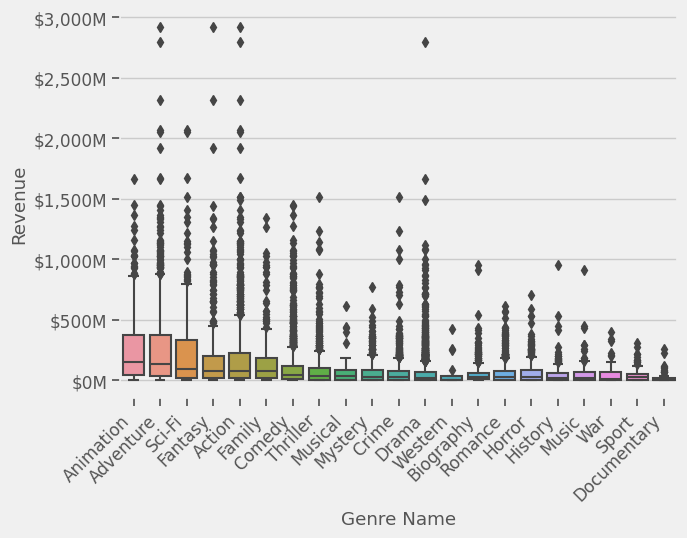

In [83]:
ax = sns.boxplot(data=df_eda,y=measure_col , x=group_col, order=genre_order)
ax.yaxis.set_major_formatter(mill_fmt)
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, ha='right');

In [84]:
# groups_cleaned = {}

# for sector, data in groups.items():

#     outliers = np.abs(stats.zscore(data)) > 3
#     print(f"There were {outliers.sum()} ({outliers.sum()/len(outliers)*100:.2f}%) outliers in the {sector} group.")

#     group_data = data.loc[~outliers]
#     groups_cleaned[sector] = group_data


## Remove outliers
groups_cleaned = remove_and_display_outliers(groups)


| group       |   n (original) |   # outliers | % outliers   |
|:------------|---------------:|-------------:|:-------------|
| Action      |           1251 |           26 | 2.08%        |
| Adventure   |            998 |           16 | 1.60%        |
| Animation   |            284 |            5 | 1.76%        |
| Biography   |            358 |            6 | 1.68%        |
| Comedy      |           1690 |           42 | 2.49%        |
| Crime       |            810 |           11 | 1.36%        |
| Documentary |            103 |            2 | 1.94%        |
| Drama       |           2275 |           38 | 1.67%        |
| Family      |            270 |           10 | 3.70%        |
| Fantasy     |            352 |            7 | 1.99%        |
| History     |            157 |            4 | 2.55%        |
| Horror      |            586 |           11 | 1.88%        |
| Music       |            155 |            3 | 1.94%        |
| Musical     |             42 |            1 | 2.38%  

We will remove the small number of outliers in runtime.

### Checking for Equal Var

In [85]:
## Check for equal variance
result = stats.levene(*groups_cleaned.values())
print(result)
if result.pvalue < .05:
    print(f"- The groups do NOT have equal variance.")
else:
    print(f"- The groups DO have equal variance.")

LeveneResult(statistic=108.42043594386612, pvalue=0.0)
- The groups do NOT have equal variance.


-  Groups do not have equal variance. Therefore, we will a Kruskal-Wallis test instead of a One-Way ANOVA.

### Final Test - Kruskal

In [86]:
result = stats.kruskal(*groups_cleaned.values())
print(result)
result.pvalue <.05

KruskalResult(statistic=1322.232973478133, pvalue=5.122009908940558e-268)


True

In [87]:
result.pvalue <.0001

True

Our Kruskal Wallis test returned a p-value<.0001, so we reject the null hypothesis all genres earn the same average revenue. a Tukey's Pairwise Multiple Comparison Test is needed to confirm which groups are significantly different.

### Post-Hoc Multiple Comparison Test

In [88]:
final_plot_df = pf.prep_data_for_tukeys(groups_cleaned,group_col=group_col, values_col=measure_col)
final_plot_df.head()

,Revenue,Genre Name
0,76019048.0,Comedy
11,224834564.0,Comedy
39,445135288.0,Comedy
45,169327687.0,Comedy
55,36609995.0,Comedy


#### Visualizing Final Clean Results

- Getting Annotated Result.

In [89]:
final_plot_df = pf.prep_data_for_tukeys(groups_cleaned,group_col=group_col, values_col=measure_col)
final_plot_df.head()

,Revenue,Genre Name
0,76019048.0,Comedy
11,224834564.0,Comedy
39,445135288.0,Comedy
45,169327687.0,Comedy
55,36609995.0,Comedy


In [90]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(final_plot_df[measure_col],final_plot_df[group_col])
display(tukeys_results.summary())

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,78508163.2767,0.0,55791074.1368,101225252.4165,True
Action,Animation,86495587.9617,0.0,51312895.1855,121678280.7378,True
Action,Biography,-112625999.9401,0.0,-144699900.2044,-80552099.6759,True
Action,Comedy,-82969951.0411,0.0,-102977618.8816,-62962283.2005,True
Action,Crime,-106158319.1772,0.0,-130276198.8405,-82040439.514,True
Action,Documentary,-149567965.1112,0.0,-204473779.1251,-94662151.0973,True
Action,Drama,-113828061.6396,0.0,-132679209.4714,-94976913.8078,True
Action,Family,-40105893.2152,0.0128,-76320503.193,-3891283.2373,True
Action,Fantasy,5437411.2922,1.0,-26888258.9363,37763081.5208,False
Action,History,-121164732.0603,0.0,-166641139.9214,-75688324.1991,True


- Figure saved as Images/hypotheses/revenue-by-genre.png


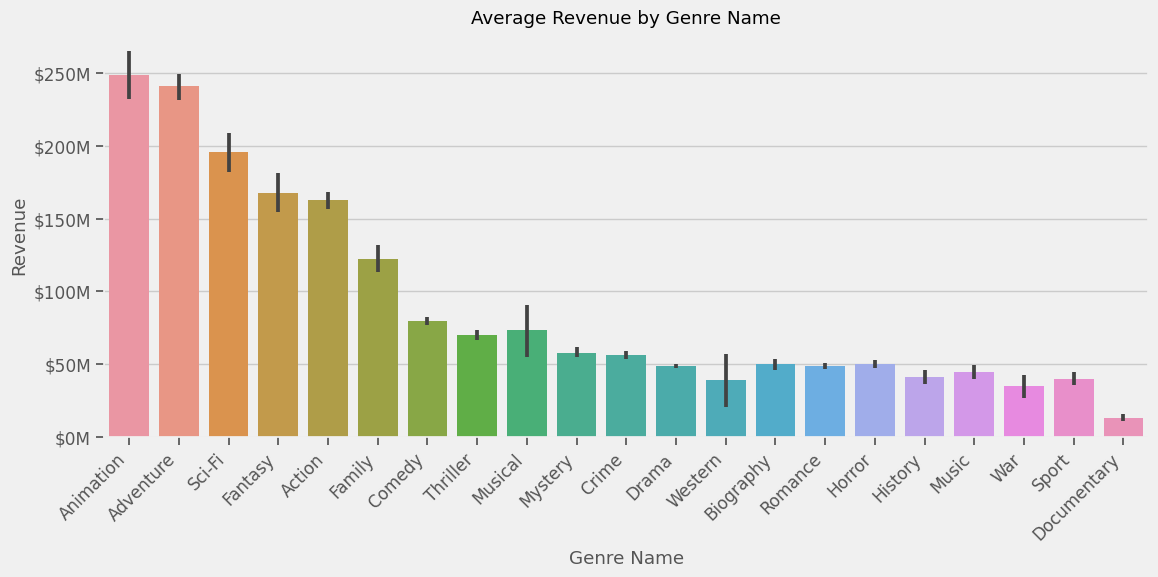

In [91]:
fig, ax  = plt.subplots(figsize=(12,5))
sns.barplot(data=final_plot_df, x=group_col, y=measure_col, errorbar=('ci',68),ax=ax, order=genre_order)
ax.set_title(f"Average {measure_col} by {group_col}");
ax.yaxis.set_major_formatter(mill_fmt)
# pf.annotate_tukey_significance(ax, tukeys_results)
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, ha='right');
pf.savefig('Images/hypotheses/revenue-by-genre.png',ax=ax)

- Figure saved as Images/hypotheses/revenue-by-genre_tukeys_full.png
- Figure saved as Images/hypotheses/revenue-by-genre_tukeys_Animation.png
- Figure saved as Images/hypotheses/revenue-by-genre_tukeys_Adventure.png
- Figure saved as Images/hypotheses/revenue-by-genre_tukeys_Sci-Fi.png
- Figure saved as Images/hypotheses/revenue-by-genre_tukeys_Action.png
- Figure saved as Images/hypotheses/revenue-by-genre_tukeys_Fantasy.png


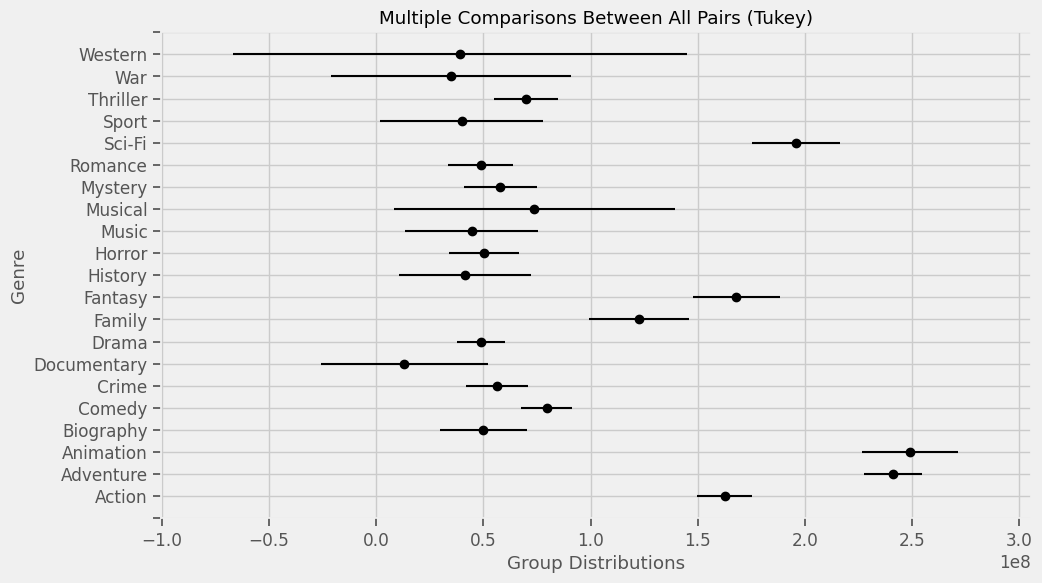

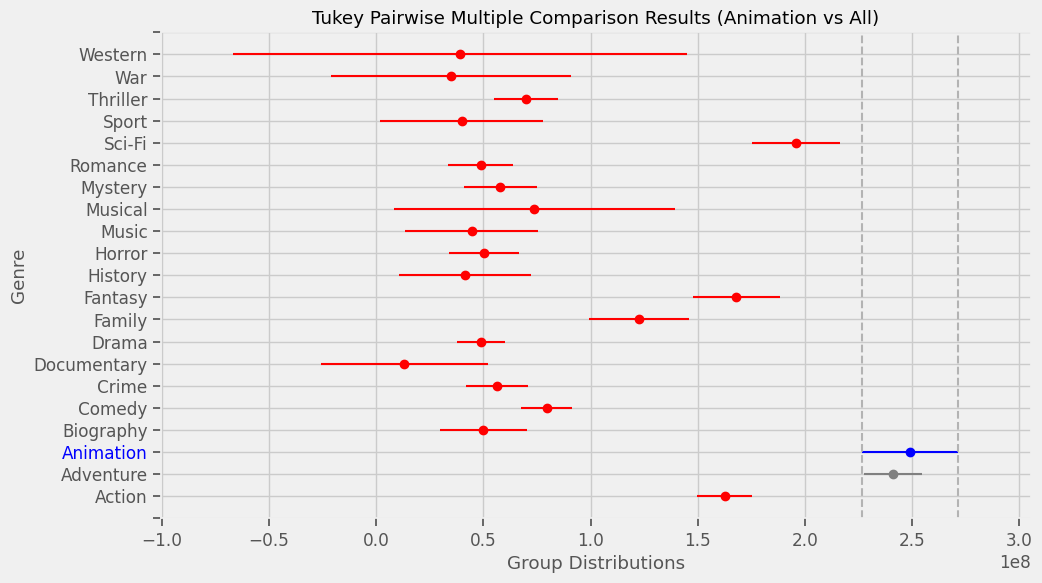

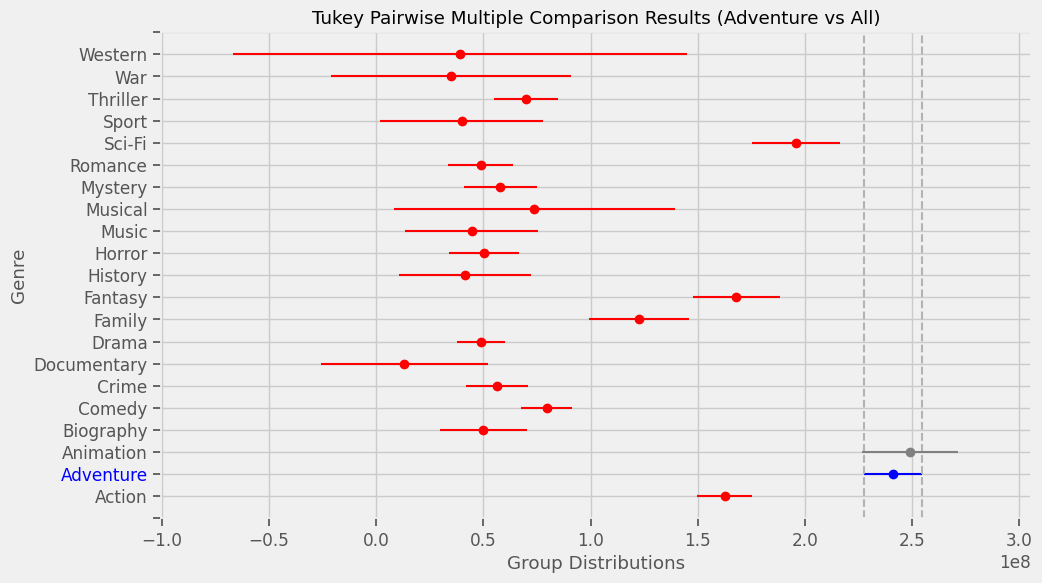

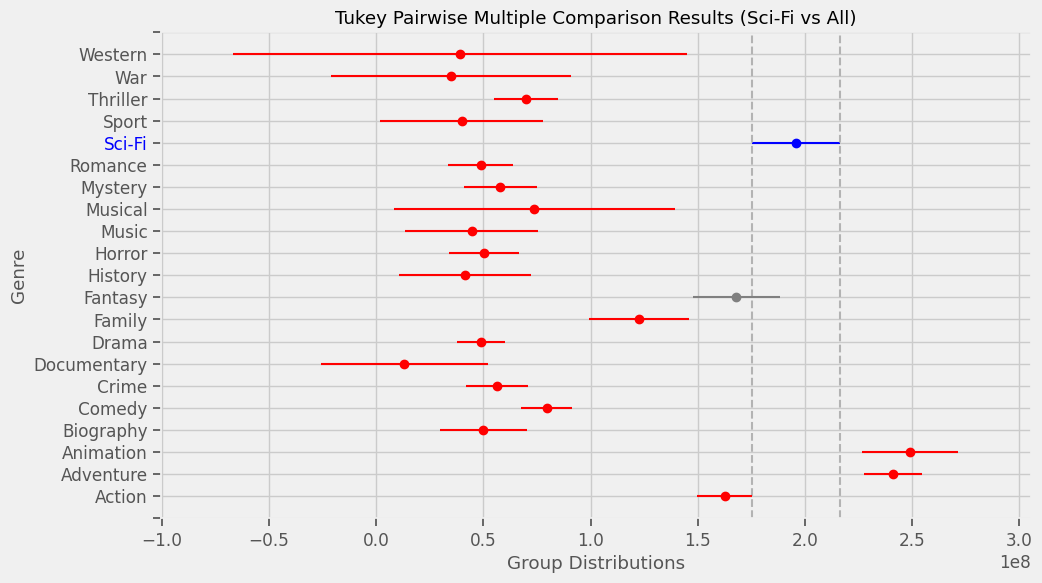

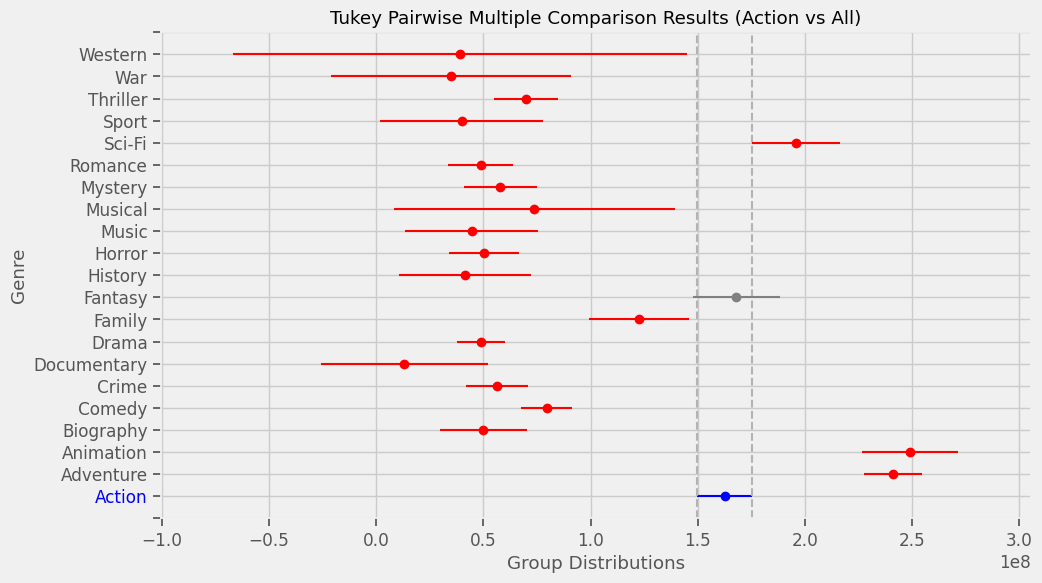

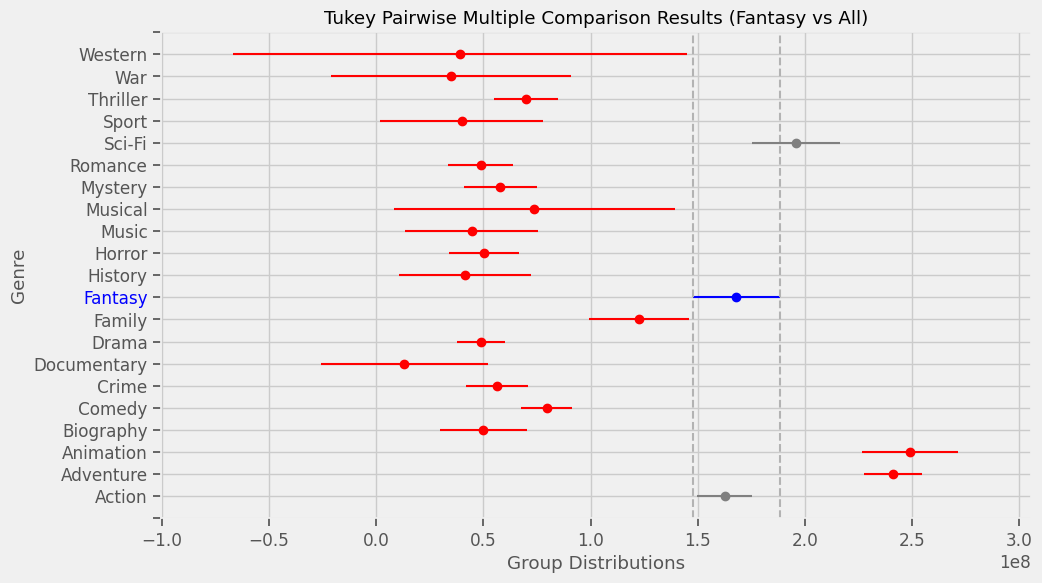

In [92]:
# def plot_simultaneous_comparison( tukeys_results, compare_group = None,compare_color='blue', figsize=(10,10), ):
#     """Plot a tukey's result plot_simultaneous with option to use "compare_group" to selectively color the group blue.
#     Any significantly different groups will appear in red.
#     If compare_group is not none, the name of the group is also annotated in blue.
#     """
#     fig, ax = plt.subplots(figsize=figsize)
#     tukeys_results.plot_simultaneous(ylabel="Genre", xlabel="Group Distributions",ax=ax, comparison_name=compare_group);
#     if compare_group is not None:
        
#         ax.set_title(f"Tukey Pairwise Multiple Comparison Results ({compare_group} vs All)");
#         # Highlighting the specified group
#         for label in ax.get_yticklabels():
#             if label.get_text() == compare_group:
#                 label.set_color(compare_color)  # Change color to red for the compare_group

#     return fig, ax



for compare_group in [None,'Animation','Adventure','Sci-Fi','Action' ,'Fantasy']:
    
    fig, ax = pf.plot_simultaneous_comparison(tukeys_results, compare_group=compare_group)
    if compare_group is None:
        compare_group = "full"
    pf.savefig(f'Images/hypotheses/revenue-by-genre_tukeys_{compare_group}.png', fig=fig)

In [93]:
normal_df = pf.check_assumptions_normality(groups)
normal_df.sort_values(by='n', ascending=False)

n     stat             p  p (.4)  \
stat test                group                                              
Shapiro-Wilk (Normality) Drama        2275  0.43823  0.000000e+00  0.0000   
                         Comedy       1690  0.58826  0.000000e+00  0.0000   
                         Action       1251  0.64001  2.802597e-45  0.0000   
                         Adventure     998  0.73643  5.095545e-37  0.0000   
                         Crime         810  0.51515  2.693296e-42  0.0000   
                         Thriller      775  0.56898  6.860687e-40  0.0000   
                         Romance       707  0.67684  1.401038e-34  0.0000   
                         Horror        586  0.68522  1.385147e-31  0.0000   
                         Mystery       522  0.69050  8.042999e-30  0.0000   
                         Biography     358  0.55211  3.115211e-29  0.0000   
                         Fantasy       352  0.59515  7.266845e-28  0.0000   
                         Sci-Fi        346  0.70632  3.559212e-24  0.0000   
                         Animation     284  0.81092  6.762745e-18  0.0000   
                         Family        270  0.66299  8.070077e-23  0.0000   
                         History       157  0.50536  7.117573e-21  0.0000   
                         Music         155  0.52749  2.514088e-20  0.0000   
                         Sport         107  0.72344  6.642578e-13  0.0000   
                         Documentary   103  0.48320  2.330710e-17  0.0000   
                         War            57  0.63047  1.013737e-10  0.0000   
                         Musical        42  0.64860  8.861620e-09  0.0000   
                         Western        19  0.57144  2.311723e-06  0.0000   

                                      sig?  
stat test                group              
Shapiro-Wilk (Normality) Drama        True  
                         Comedy       True  
                         Action       True  
                         Adventure    True  
                         Crime        True  
                         Thriller     True  
                         Romance      True  
                         Horror       True  
                         Mystery      True  
                         Biography    True  
                         Fantasy      True  
                         Sci-Fi       True  
                         Animation    True  
                         Family       True  
                         History      True  
                         Music        True  
                         Sport        True  
                         Documentary  True  
                         War          True  
                         Musical      True  
                         Western      True

In [94]:
len(normal_df)

21

# APPENDIX

In [95]:
raise Exception("old dev code below")

Exception: old dev code below

## Function Development

In [ ]:
## make a list for saving the dataframes to
tukeys_dfs = []
for cert, temp in groups.items():
    temp_df = pd.DataFrame({'Revenue':temp, 'Certification':cert})
    tukeys_dfs.append(temp_df)
    
## concatenate them into 1 dataframe    
tukeys_data = pd.concat(tukeys_dfs)
tukeys_data

In [ ]:
tukeys_data['Certification'].value_counts()

In [ ]:
## Post Hoc
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# values = tukeys_data['revenue']
# labels = tukeys_data['certification']

In [ ]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(tukeys_data['Revenue'],tukeys_data['Certification'])
display(tukeys_results.summary())

In [ ]:
# raw_tukeys_data = tukeys_results._results_table.data
# pd.DataFrame(raw_tukeys_data[1:],columns=raw_tukeys_data[0])

In [ ]:
# # making into a dict

# sig_dict= {'*':"p < .05",
#           "**":"p < .01",
#           "***":"p < .001"}
# # asts = "***"
# # print(f'{asts:>3} p < 0.001')

# # asts = "**"
# # print(f'{asts:>3} p < 0.01')

# # asts = "*"
# # print(f'{asts:>3} p < 0.05')

# labels = []
# for asts, pval in sig_dict.items():
#     label =  f'{asts:>3} {pval}'
#     labels.append(label)
# print('\n'.join(labels))

In [ ]:
def add_sig_legend(ax, frame=True, bbox_to_anchor=(1,1), title='Significance Levels', marker='',
                  color=None, alignment='center'):
    from matplotlib.lines import Line2D
    sig_dict= {"***":"p < .001",
               "**":"p < .01",
        '*':"p < .05"}
    
    legend_elements = []
    for asts, pval in sig_dict.items():
        label =  f'{asts:<5}  {pval:>10}'
        legend_elements.append( Line2D([0], [0], marker=marker, color=color, markerfacecolor='k',linewidth=0, markersize=0, label=label))
    
    # Add the legend to the plot
    ax.legend(handles=legend_elements, #loc='upper right',
              bbox_to_anchor = bbox_to_anchor,
              frameon=frame,title=title, alignment=alignment)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker

def annotate_tukey_significance(ax, tukey_results, delta_pad_line = 0.06, 
                                delta_pad_text=0.02, delta_err = 1.05,
                                linewidth=.75, fontsize=8, legend=True):
    """
    Annotate a barplot with Tukey's HSD test significance, ensuring annotations do not overlap.

    Parameters:
    - ax: The matplotlib axis object containing the barplot.
    - tukey_results: DataFrame with columns ['group1', 'group2', 'p-adj', 'reject'].
    - group_order: List of groups in the same order as they appear in the barplot.
    - delta_pad_line: Proportional padding above each annotation line.
    - delta_pad_text: Proportional padding above the text relative to its line.
    - delta_err: Proportional padding for first annotation relative to error bar.
    - linewidth: Width of the annotation lines.
    - fontsize: Size of the annotation text.
    """
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib import ticker as mticker

    # Get results as a dataframe
    if not isinstance(tukeys_results, pd.DataFrame):
        raw_tukeys_data = tukey_results._results_table.data
        tukey_results = pd.DataFrame(raw_tukeys_data[1:],columns=raw_tukeys_data[0])


    # Determine the height of the highest errorbar
    highest_bar = max([p.get_height() for p in ax.patches])
    highest_errorbar = highest_bar * delta_err#1.1  # Assuming errorbar might add 10% height, adjust this based on your error calculation
    
        
    # Determine the initial y-axis height to start the annotations
    initial_y_max = highest_errorbar#ax.get_ylim()[1]
    y_max = initial_y_max * delta_err#1.1
    ax.set_ylim(top=y_max)
    
    # Fixed distance above the last annotation for the next one
    delta = initial_y_max * delta_pad_line#0.06  # Adjust this value based on your plot's scale
    
    # Variable to keep track of the last annotation's height
    last_annotation_height = y_max

    # Extract group order from x-axis labels
    group_order = [tick.get_text() for tick in ax.get_xticklabels()]
    
    # Iterate through Tukey's test results
    for _, row in tukey_results.iterrows():
        if row['reject']:  # If the result is significant
            # Find the positions of the groups on the x-axis
            group1_pos = group_order.index(row['group1'])
            group2_pos = group_order.index(row['group2'])
            x_mid = (group1_pos + group2_pos) / 2  # Midpoint for the annotation

            # Determine significance level for annotation
            if row['p-adj'] < 0.001:
                sig = '***'
            elif row['p-adj'] < 0.01:
                sig = '**'
            elif row['p-adj'] < 0.05:
                sig = '*'
            else:
                sig = ''  # No asterisks for non-significant differences
            
            # Calculate the height for the annotation, ensuring it's above the last one
            y = last_annotation_height + delta  # Increment from last height
            
            # Draw the line and the annotation
            ax.plot([group1_pos, group2_pos], [y, y], lw=linewidth, color='black')
            ax.text(x_mid, y + (delta * delta_pad_text), sig, ha='center', va='bottom', fontweight='semibold',fontsize=fontsize)  # Slightly above the line
            
            # Update the last_annotation_height to the current y position
            # last_annotation_height = y
            last_annotation_height += delta + (delta * delta_pad_text)


    # Adjust the plot's ylim to accommodate the last annotation
    ax.set_ylim(top=last_annotation_height + delta)

    if legend:
        add_sig_legend(ax)
        

# # Example usage remains the same
# ax = sns.barplot(data=tukeys_data, x='Certification', y='Revenue', errorbar=('ci', 68), order=cert_order)
# ax.yaxis.set_major_formatter(mill_fmt)
# ax.set_title("Final Average Revenue per MPAA Rating")
# # Call the annotation function
# annotate_tukey_significance(ax, tukeys_results)#, delta_pad_text=0.02)
# pf.savefig('Images/hypotheses/revnue_mpaa_rating.png',ax=ax)#facecolor='white')

In [ ]:
# Example usage remains the same
ax = sns.barplot(data=tukeys_data, x='Certification', y='Revenue', errorbar=('ci', 68), order=cert_order)
ax.yaxis.set_major_formatter(mill_fmt)
ax.set_title("Final Average Revenue per MPAA Rating")
# Call the annotation function
pf.annotate_tukey_significance(ax, tukeys_results)#, delta_pad_text=0.02)
pf.savefig('Images/hypotheses/revnue_mpaa_rating.png',ax=ax)#facecolor='white')

### Testing for Normality (as Markdown)

In [ ]:
# def check_assumptions_normality(groups_dict, alpha=.05):
#     """
#     The Shapiro-Wilk test tests the null hypothesis that the
#     data was drawn from a normal distribution.
#     """
#     ## Running normal test on each group and confirming there are >20 in each group
#     results = []
#     for group_name, group_data in groups_dict.items():
#         try:
#             stat, p = stats.shapiro(group_data)
#             test_name = 'Shapiro-Wilk (Normality)'
#         except:
#             print(f'[!] Error with {i}')
#             p = np.nan
            
#         ## save the p val, test statistic, and the size of the group
#         results.append({'stat test':test_name, 'group':group_name, 
#                         'n': len(group_data),
#                          'stat':f"{stat:.5f}",
#                         'p':p,#f"{p:.10f}",
#                         'p (.4)':f"{p:.4f}",
#                         'sig?': p<alpha})
        
#     return pd.DataFrame(results).set_index(['stat test',"group"])


In [ ]:
# # Prepare Normality Resuls as markdown
# def normal_results_to_markdown(normal_results, sort_by='group'):
#     normal_results = normal_results.reset_index()
#     normal_results = normal_results.drop(columns=['stat test'])
#     normal_results.sort_values(by=sort_by)
    
#     return normal_results.to_markdown(index=False)

In [ ]:
# normal_results = pf.check_assumptions_normality(groups)
# normal_results

In [ ]:
# normal_results_md = normal_results_to_markdown(normal_results)
# print(normal_results_md)